In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
BATCH_SIZE = 32

raster_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(x.shape[0], -1)),  # (C,H,W) -> (C, H*W)
    ]
)

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=raster_transform
)

dataset_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=raster_transform
)

train_loaded = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

test_loaded = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 84.5MB/s] 


In [12]:
import random
idx = random.randint(0, len(dataset_train) - 1)
img, label = dataset_train[idx]
img, label

(tensor([[0.1922, 0.2196, 0.3373,  ..., 0.3569, 0.3490, 0.3255],
         [0.1882, 0.2078, 0.3216,  ..., 0.3176, 0.3098, 0.2941],
         [0.1922, 0.2118, 0.3294,  ..., 0.2824, 0.2784, 0.2667]]),
 4)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CausalConv1d(nn.Module):
    """
    Causal 1D convolution.
    - Type B (A=False): y[t] depends on x[t] and past.
    - Type A (A=True):  y[t] depends ONLY on x[t-1] and past (excludes current x[t]).
    """

    def __init__(
        self, in_channels, out_channels, kernel_size, dilation=1, A=False, **kwargs
    ):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A

        # Base causal left padding
        base_pad = (kernel_size - 1) * dilation
        # Type A needs one extra shift to exclude current input x[t]
        self.left_pad = base_pad + (1 if A else 0)

        self.conv1d = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=0,  # we do manual left padding only
            dilation=dilation,
            **kwargs
        )

    def forward(self, x):
        """
        x: (B, C_in, L)
        returns:
          - Type B: (B, C_out, L)
          - Type A: (B, C_out, L) aligned so y[t] never uses x[t]
        """
        # left pad only
        x = F.pad(x, (self.left_pad, 0))
        y = self.conv1d(x) 

        if self.A:
            y = y[..., :-1]  # (B, C_out, L)

        return y

In [6]:
from tqdm.auto import tqdm
def train_next_pixel_regression(model, train_loader, epochs=5, lr=1e-3, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss, total = 0.0, 0

        for x, _ in train_loader:
            x = x.to(device)  # (B, 3, 1024), values in [0,1] if ToTensor()

            # teacher forcing: predict next step
            x_in = x[:, :, :-1]  # (B, 3, 1023)
            y_target = x[:, :, 1:]  # (B, 3, 1023)

            optimizer.zero_grad()
            y_pred = model(
                x_in
            )  # should be (B, 3, 1023) or (B, C_out, 1023) with a head to 3
            loss = criterion(y_pred, y_target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += x.size(0)

        print(f"Epoch {epoch}: train_loss={running_loss/total:.6f}")

In [7]:
model = CausalConv1d(3, 3, 5, 1)

causal_conv1d = train_next_pixel_regression(model, train_loaded, epochs=5, lr=1e-3, device=None)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: train_loss=0.021092
Epoch 2: train_loss=0.010093
Epoch 3: train_loss=0.009042
Epoch 4: train_loss=0.008753
Epoch 5: train_loss=0.008621


In [8]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_image_raster(model, H=32, W=32, device=None, clamp=True, add_noise=0.0):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    L = H * W
    x = torch.zeros(
        1, 3, L, device=device
    ) 
    x[:, :, 0] = torch.rand(1, 3, device=device)  

    for t in range(0, L - 1):
        x_in = x[:, :, : t + 1]  # (1, 3, t+1)
        y_pred = model(x_in)  # (1, 3, t+1)
        next_val = y_pred[:, :, -1]  # (1, 3)
        if add_noise > 0:
            next_val = next_val + add_noise * torch.randn_like(next_val)
        if clamp:
            next_val = next_val.clamp(0.0, 1.0)

        x[:, :, t + 1] = next_val
    img = x.view(1, 3, H, W).cpu()
    plt.imshow(img.squeeze(0).permute(1, 2, 0))
    return img

tensor([[[[0.1338, 0.2872, 0.2790,  ..., 0.4080, 0.4112, 0.4143],
          [0.4172, 0.4200, 0.4226,  ..., 0.4606, 0.4612, 0.4618],
          [0.4623, 0.4628, 0.4633,  ..., 0.4697, 0.4698, 0.4699],
          ...,
          [0.4713, 0.4713, 0.4713,  ..., 0.4713, 0.4713, 0.4713],
          [0.4713, 0.4713, 0.4713,  ..., 0.4713, 0.4713, 0.4713],
          [0.4713, 0.4713, 0.4713,  ..., 0.4713, 0.4713, 0.4713]],

         [[0.8417, 0.8132, 0.6532,  ..., 0.4683, 0.4665, 0.4648],
          [0.4633, 0.4620, 0.4607,  ..., 0.4518, 0.4518, 0.4519],
          [0.4519, 0.4520, 0.4521,  ..., 0.4541, 0.4541, 0.4542],
          ...,
          [0.4561, 0.4561, 0.4561,  ..., 0.4561, 0.4561, 0.4561],
          [0.4561, 0.4561, 0.4561,  ..., 0.4561, 0.4561, 0.4561],
          [0.4561, 0.4561, 0.4561,  ..., 0.4561, 0.4561, 0.4561]],

         [[0.1011, 0.3510, 0.2686,  ..., 0.2959, 0.2986, 0.3012],
          [0.3038, 0.3064, 0.3090,  ..., 0.3594, 0.3606, 0.3618],
          [0.3629, 0.3639, 0.3650,  ..., 0

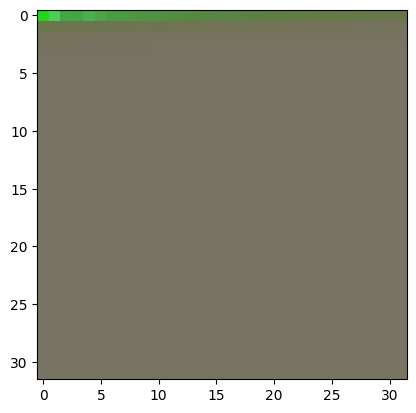

In [9]:
sample_image_raster(model)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CausalConv1dV2(nn.Module):
    """
    Causal 1D convolution.
    - Type B (A=False): y[t] depends on x[t] and past.
    - Type A (A=True):  y[t] depends ONLY on x[t-1] and past (excludes current x[t]).
    """

    def __init__(
        self, in_channels, out_channels, kernel_size, dilation=1, A=False, **kwargs
    ):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A

        # Base causal left padding
        base_pad = (kernel_size - 1) * dilation
        # Type A needs one extra shift to exclude current input x[t]
        self.left_pad = base_pad + (1 if A else 0)

        self.conv1d = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=0,  # we do manual left padding only
            dilation=dilation,
            **kwargs
        )

    def forward(self, x):
        """
        x: (B, C_in, L)
        returns:
          - Type B: (B, C_out, L)
          - Type A: (B, C_out, L) aligned so y[t] never uses x[t]
        """
        # left pad only
        x = F.pad(x, (self.left_pad, 0))
        y = self.conv1d(x)

        if self.A:
            y = y[..., :-1]  # (B, C_out, L)

        return y